# Making Estimations with our NBA dataset

Now we are going to explore how to make predictive models for regression and classification tasks using ScikitLearn

## Using Regression Models to Estimate players Salaries

### Analyzing our data

In [3]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
data.dropna(subset=["PTS"], inplace=True)

In [9]:
!pip install sklearn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 7.4/7.4 MB 10.7 MB/s eta 0:00:00
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
  Running setup.py install for sklearn: started
  Running setup.py install for sklearn: finished with status 'done'


In [11]:
# Basic operation labaries:
import numpy as np
import pandas as pd
import io
import itertools

# Data visualization:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools:

# machine learning models:
from sklearn.linear_model     import LogisticRegression
from sklearn.tree             import DecisionTreeRegressor
from sklearn.linear_model     import SGDRegressor

# splitting data:
from sklearn.model_selection  import train_test_split

# Features numeric normalization:
from sklearn.preprocessing    import StandardScaler, MinMaxScaler

# Features categorical normalization:  
from sklearn.preprocessing    import OneHotEncoder

# model metric evaluation:
from sklearn.metrics          import mean_absolute_error
from sklearn.metrics          import confusion_matrix
from sklearn.metrics          import precision_score
from sklearn.metrics          import recall_score
from sklearn.metrics          import f1_score
from sklearn.metrics          import accuracy_score

# tyding up the code (in the future):
from sklearn.pipeline         import make_pipeline

# visualizing results:
from sklearn.metrics          import fbeta_score, make_scorer

from sklearn.model_selection  import learning_curve

# For the future, hyperparameths selector:
from sklearn.model_selection  import GridSearchCV


Let's have another look at our previously generated dataset. 

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

In [12]:
data.head(3)
#data.columns
#data.describe()
#data.info()

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,Salary,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,1,20,115.0,17.3,6.5,5.1,0.8,0.4,0.5,2022-03-06,2711280,"22 years, 5 months, 25 days"
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,8,12,648.0,26.8,9.3,7.9,1.4,0.9,0.9,2022-03-06,17073171,"28 years, 7 months, 24 days"
2,1628389,Bam Adebayo,Heat,Center,206,116,USA,1997-07-18,4,14,326.0,28.0,13.2,8.2,3.5,1.0,0.9,2022-03-07,28103550,"24 years, 7 months, 26 days"


In [13]:
%pylab
%matplotlib inline

Using matplotlib backend: <object object at 0x000002295EFA30E0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


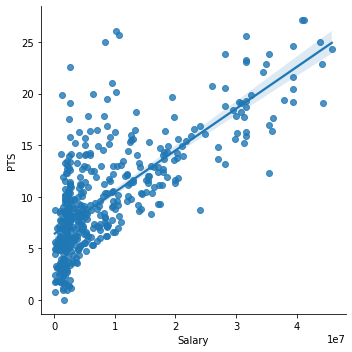

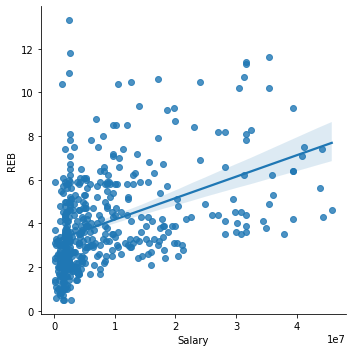

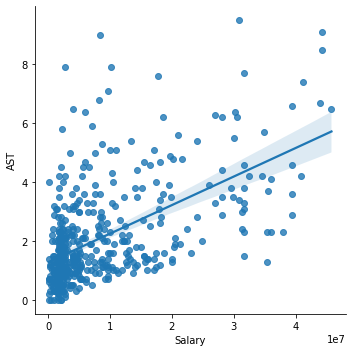

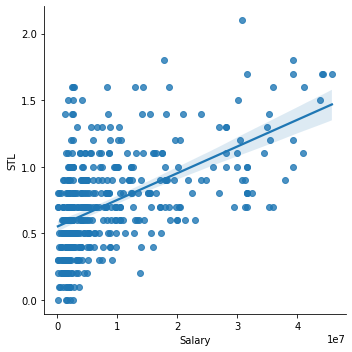

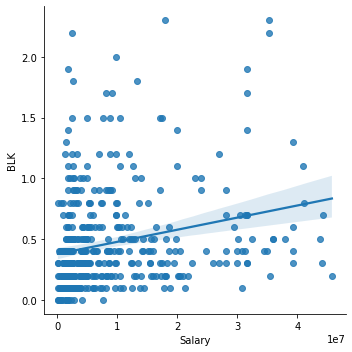

In [ ]:
# Ploting ["PTS", "REB", "AST","STL","BLK"] vs salary:

features = ["PTS", "REB", "AST","STL","BLK"]

for feature in features:
  ax=sns.lmplot(x="Salary",y = feature,  data = data)

It's seems to have a lineal proportion with salary, for the rest is not that obvious. SLT and BLK could be considered discrete variables.

##Correlation analysis:

### Splitting the Dataset

Text(0.5, 1.0, 'Correlation Heatmap')

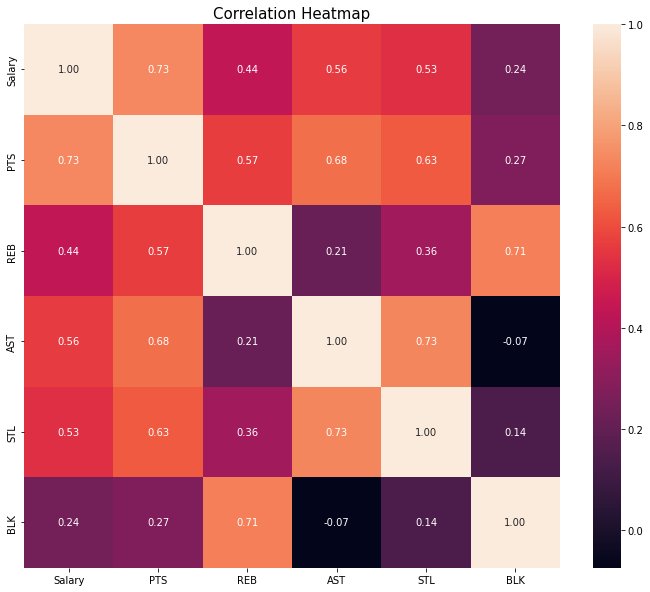

In [14]:
#Correlation
plt.figure(figsize=(12,10))

ax = sns.heatmap(data[['Salary',"PTS", "REB", "AST","STL","BLK"]].corr(), annot=True, fmt='.2f')
ax.set_title('Correlation Heatmap', fontsize=15)

<Figure size 1008x1008 with 0 Axes>

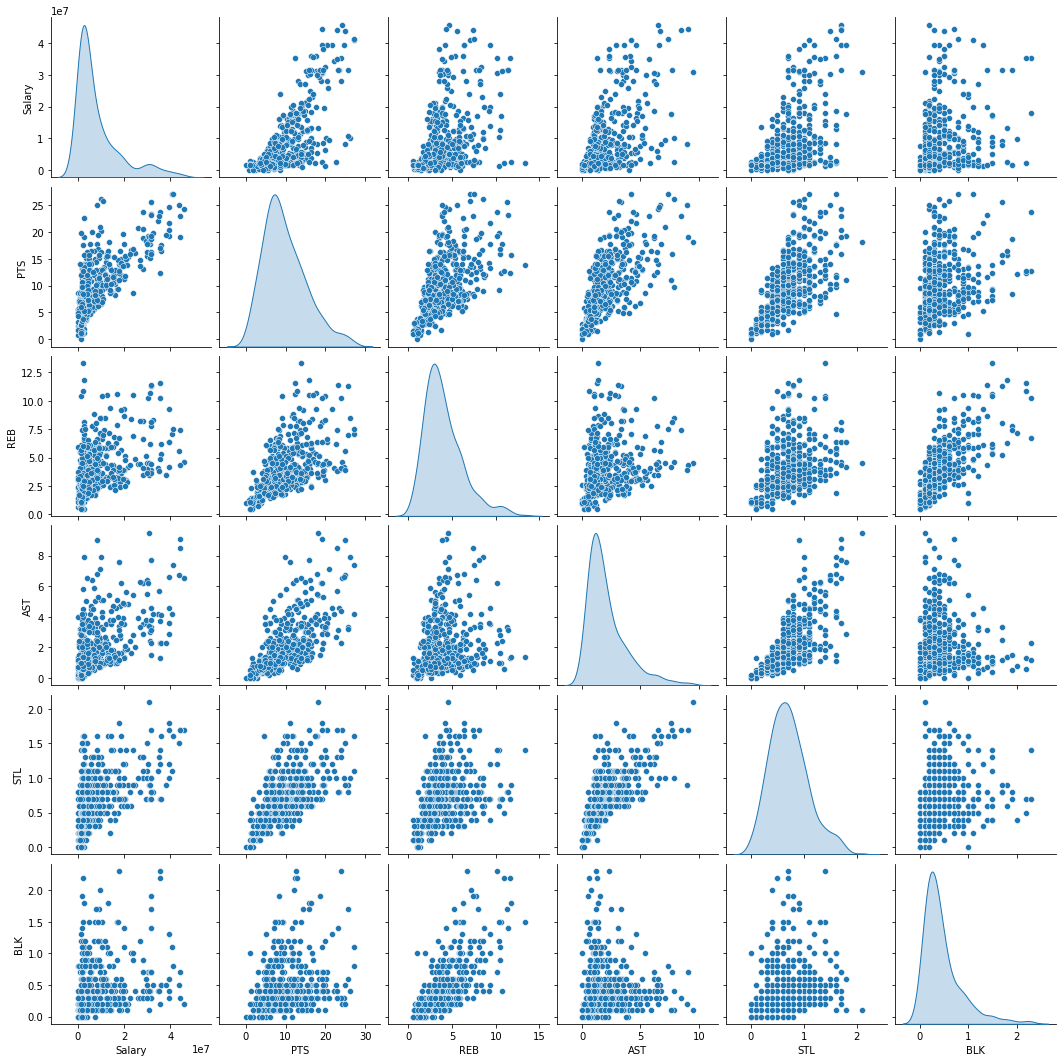

In [15]:
plt.figure(figsize=(14, 14))
ax = sns.pairplot(data[['Salary',"PTS", "REB", "AST","STL","BLK"]], diag_kind='kde')

Now we split the dataset into train and testing sets. 

In [16]:
# In order to have repeatability in pur experiments is important to plant a seed. I chose the 22 as a random_state.
targets = data['Salary']
inputs =  data.drop(['Salary'],axis=1)

x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=22)

x_train ---> features we are going to use to train the model.

y_train ---> targuet that we are going to use to train the model (is a supervised model).

x_test ---> features we are going to use to test the model.

y_test ---> targuet we are going to use to test our model.

In [19]:
print('Train x: ',len(x_train), 'Train y: ',len(y_train))
print('Test x: ',len(x_test),'Test y: ',len(y_test))

Train x:  367 Train y:  367
Test x:  92 Test y:  92


### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

So now we create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [20]:
class BaselineModel():
  
  """
  This model will compute the mean of the players salary from our training dataset 
  and will use that value as the predicted value for any given input.
  """

  def fit(self, y_train):
     """
     Fit the training data. 
     
     Parameters
     ----------
     y_train: Union[pd.Series, np.ndarray]
         a pandas series or numpy array containing salary information
     """
     self.mean_salary = np.mean(y_train)
    
  def predict(self, X):
    """
    Predict salaries 
  
    Parameters
    ----------
    X: Union[pd.DataFrame, pd.Series, np.ndarray]
      a pandas series, dataframe or numpy array with the 
      
    Returns
    -------
    np.ndarray
    a numpy array of the same length as X, with all elements equal to the mean salary calculated in fit()
    """
    
    return np.array([self.mean_salary] * len(X))

Evaluating the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [21]:
model_1 = BaselineModel()
model_1.fit(y_train)
y_pred = model_1.predict(x_test)
mae_bl = round(mean_absolute_error(y_test, y_pred),0)
print(mae_bl)

7307666.0


### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


<AxesSubplot:xlabel='PTS', ylabel='Count'>

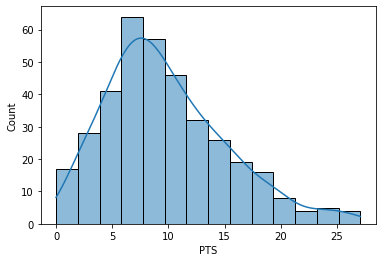

In [22]:
# I chose PTS, so first I see how is the distribution:

sns.histplot(x_train['PTS'], kde=True)

In [24]:
# The StandarsScaler normalize  the numeric fetures that have an (aproximate) gaussian distribution:
# 1) call the scaller:
scaler = StandardScaler()

# 2) fit and transform ---> with x_train
x_train_pts = scaler.fit_transform(x_train['PTS'].values.reshape(-1,1))

# 3) transform the x_test
x_test_pts = scaler.transform(x_test['PTS'].values.reshape(-1,1))
#scaler_x_train_PTS = scaler.transform(x_train['PTS'].values.reshape(-1,1))
#scaler_x_train_PTS

<AxesSubplot:ylabel='Count'>

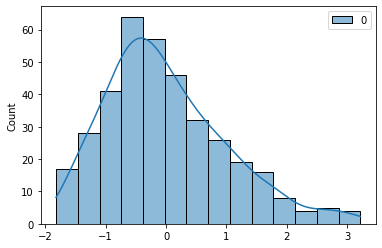

In [25]:
sns.histplot(x_train_pts, kde=True)

<AxesSubplot:ylabel='Count'>

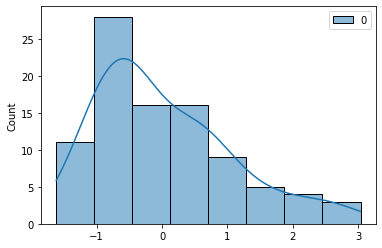

In [26]:
sns.histplot(x_test_pts, kde=True)

Lets train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

In [27]:
model_lr= SGDRegressor()
model_lr.fit(x_train_pts,y_train)
y_result = model_lr.predict(x_test_pts)

mae_sgd = mean_absolute_error( y_test, model_lr.predict(x_test_pts))

print(mae_sgd)


4739464.196942524


The following function tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [28]:
def search_best_hyperparameters(epochs, learning_rates, alphas):
    result = {
        "hyperparameters": {"epochs": None, "lr": None, "alpha": None}, 
        "mae": None
    }
    # Complete your code here:
    
    # For each combination of parameters: 
    #   evaluate the trained algorithm on the test set, 
    #   then save the results of each hyperparameter combination, 
    #   finally select the one that has the best MAE (meaning the lowest number) 
    #   and print the combination and the MAE.
    
    mae_low = 10000000000000
    
    for i in epochs:
      for j in learning_rates:
        for k in alphas:
          
          # I call the model with the hiperparameters i, j, k:
          sgd_lr = SGDRegressor(loss='squared_error', alpha = k, eta0 = j, max_iter = i)
          
          # I fit the model:
          sgd_lr.fit(x_train_pts, y_train)
          
          # I calculate the mean sq error:
          mae = mean_absolute_error( y_test, sgd_lr.predict(x_test_pts))
          
          # mae is always > 0:
          if mae < mae_low:
            mae_low = mae
            result ['mae'] = round(mae,4)
            result ['hyperparameters'] = {"epochs": i, "lr": j, "alpha": k}
    
    return result

In [29]:
# Example list of hyperparameters values
max_iter = [1000, 1000000]
eta0 = [0.2, 0.001, 0.01, 0.1]
alphas = [0.2, 1, 0.01, 0.1]
result = search_best_hyperparameters(max_iter, eta0,alphas)
print(result)

{'hyperparameters': {'epochs': 1000000, 'lr': 0.2, 'alpha': 0.01}, 'mae': 4697474.5525}


Of course in real life we use GridSearch or RandomSearch

Now we compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. 

In [30]:
print("Mean Absolute Error for each model:" )
print(f"Baseline: {mae_bl}")
print(f"Default SGDRegressor: {mae_sgd}")
print(f"Best SGDRegressor: {result.values()}")

Mean Absolute Error for each model:
Baseline: 7307666.0
Default SGDRegressor: 4739464.196942524
Best SGDRegressor: dict_values([{'epochs': 1000000, 'lr': 0.2, 'alpha': 0.01}, 4697474.5525])


For now the SGDRegressor with the searched hyper. had the best performance.

### Multivariate Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index):

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "TEAM_NAME", "SALARY"]

In [31]:
df = data[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER",  "TEAM_NAME", "Salary"]]
df = df.rename(columns={"Salary": "SALARY"})
df.head(2)

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,TEAM_NAME,SALARY
0,6.5,5.1,0.8,0.5,1,Forward,20,Raptors,2711280
1,9.3,7.9,1.4,0.9,8,Center,12,Grizzlies,17073171


#### Feature Engineering

Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted

In [32]:
df.DRAFT_NUMBER.unique()
df.DRAFT_NUMBER = df.DRAFT_NUMBER.replace(['Undrafted', nan], '0')
df.DRAFT_NUMBER.unique()
df.DRAFT_NUMBER = df.DRAFT_NUMBER.astype(float).astype(int)


In [33]:
def get_gen_draft(draft_number):
      
      if (draft_number > 1) & (draft_number <= 15):
          return 'firstround_lottery'

      elif (draft_number > 15) & (draft_number <= 30):
          return 'firstround_non_lottery'

      elif (draft_number > 30) & (draft_number <= 60):
          return 'second_round'

      else:
          return 'undrafted'

In [34]:
df['DRAFT'] = df.DRAFT_NUMBER.apply(get_gen_draft) 
df.drop(columns=['DRAFT_NUMBER'], inplace = True)
df.head(10)

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,TEAM_NAME,SALARY,DRAFT
0,6.5,5.1,0.8,0.5,1,Forward,Raptors,2711280,firstround_non_lottery
1,9.3,7.9,1.4,0.9,8,Center,Grizzlies,17073171,firstround_lottery
2,13.2,8.2,3.5,0.9,4,Center,Heat,28103550,firstround_lottery
3,3.3,2.4,0.5,0.3,0,Forward,Grizzlies,1994520,firstround_non_lottery
4,19.1,8.1,1.9,1.1,15,Center,Nets,2641691,firstround_lottery
5,9.7,2.7,2.3,0.3,2,Guard,Jazz,3261480,firstround_non_lottery
6,9.3,2.5,1.5,0.2,3,Guard,Bucks,4054695,firstround_non_lottery
7,11.6,8.7,1.4,1.4,4,Center,Cavaliers,20000000,firstround_non_lottery
8,6.6,4.4,2.3,0.6,7,Forward,Grizzlies,9937150,firstround_non_lottery
9,21.6,9.3,4.6,1.3,8,Forward,Bucks,39344970,firstround_lottery


Encode the categorical features: DRAFT, POSITION and TEAM_NAME

In [35]:
# Convert categorical features to encoded vectors using get_dummies
df = pd.get_dummies(df, columns=['DRAFT', 'POSITION','TEAM_NAME'])
df.head()


,PTS,REB,AST,BLK,SEASON_EXP,SALARY,DRAFT_firstround_lottery,DRAFT_firstround_non_lottery,DRAFT_second_round,DRAFT_undrafted,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
0,6.5,5.1,0.8,0.5,1,2711280,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,9.3,7.9,1.4,0.9,8,17073171,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13.2,8.2,3.5,0.9,4,28103550,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.3,2.4,0.5,0.3,0,1994520,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,19.1,8.1,1.9,1.1,15,2641691,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Modeling

Splitting the dataset into train and test

In [36]:
targets = df['SALARY']
inputs =  df.drop(['SALARY'],axis=1)

dfx_train, dfx_test, dfy_train, dfy_test = train_test_split(inputs, targets, test_size=0.2, random_state=22)

Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number

In [37]:
features = ["PTS", "REB", "AST", "BLK", "SEASON_EXP"]

# 1) Call the scaler
mm_scaler = MinMaxScaler(feature_range=(0, 1), clip=False)

# 2) fit:

dfx_train[features] = mm_scaler.fit_transform(dfx_train[features])#.values.reshape(-1, 1))

# 3) now on the test:

dfx_test[features] = mm_scaler.transform(dfx_test[features])#.values.reshape(-1, 1))


In [38]:
dfx_train.head(3)

,PTS,REB,AST,BLK,SEASON_EXP,DRAFT_firstround_lottery,DRAFT_firstround_non_lottery,DRAFT_second_round,DRAFT_undrafted,POSITION_Center,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
418,0.468635,0.484375,0.126316,1.000000,0.333333,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
380,0.324723,0.101562,0.168421,0.043478,0.166667,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
147,0.453875,0.867188,0.136842,0.956522,0.444444,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [39]:
dfx_test.head(3)

,PTS,REB,AST,BLK,SEASON_EXP,DRAFT_firstround_lottery,DRAFT_firstround_non_lottery,DRAFT_second_round,DRAFT_undrafted,POSITION_Center,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
66,0.206642,0.226562,0.105263,0.086957,0.222222,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
180,0.601476,0.320312,0.336842,0.086957,0.111111,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,0.188192,0.195312,0.063158,0.173913,0.166667,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [40]:
print(dfx_train.shape, dfx_test.shape)

(367, 42) (92, 42)


Now we write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [41]:
def search_best_hyperparameters2(epochs, learning_rates, alphas):
    result = {
        "hyperparameters": {"epochs": None, "lr": None, "alpha": None}, 
        "mae": None
    }
    # Complete your code here:
    
    # For each combination of parameters: 
    #   evaluate the trained algorithm on the test set, 
    #   then save the results of each hyperparameter combination, 
    #   finally select the one that has the best MAE (meaning the lowest number) 
    #   and print the combination and the MAE.

 # dfx_train, dfx_test, dfy_train, dfy_test   

    mae_low = 10000000000000
    
    for i in epochs:
      for j in learning_rates:
        for k in alphas:
          
          # I call the model with the hiperparameters i, j, k:
          sgd_lr = SGDRegressor(loss='squared_error', alpha = k, eta0 = j, max_iter = i)
          
          # I fit the model:
          sgd_lr.fit(dfx_train, dfy_train)
          
          # I calculate the mean sq error:
          mae = mean_absolute_error( dfy_test, sgd_lr.predict(dfx_test))
          
          # mae is always > 0:
          if mae < mae_low:
            mae_low = mae
            result ['mae'] = mae
            result ['hyperparameters'] = {"epochs": i, "lr": j, "alpha": k}
    
    return result

In [42]:
# Example list of hyperparameters values
max_iter = [1000, 1000000]
eta0 = [0.0001, 0.001, 0.01, 0.1]
alphas = [0.0001, 0.001, 0.01, 0.8]
result2 = search_best_hyperparameters(max_iter, eta0,alphas)
print(result2)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\User

{'hyperparameters': {'epochs': 1000, 'lr': 0.0001, 'alpha': 0.01}, 'mae': 4679491.5108}


In [43]:

print(f"Best SGDRegressor: {result.values()}")
print(f"Best SGDRegressor: {result2.values()}")

Best SGDRegressor: dict_values([{'epochs': 1000000, 'lr': 0.2, 'alpha': 0.01}, 4697474.5525])
Best SGDRegressor: dict_values([{'epochs': 1000, 'lr': 0.0001, 'alpha': 0.01}, 4679491.5108])


### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



Lets create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [44]:
# Import necessary modules
from scipy.stats             import randint
from sklearn.tree            import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth":        [5, 10, 15, 20, 50],
              "max_features":     [5, 10] ,
              "min_samples_leaf": [2, 10, 20, 50],        
              }

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(dfx_train, dfy_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))
print('The mean absolute error is: ' ,mean_absolute_error( dfy_test, tree_cv.predict(dfx_test)))

Tuned Decision Tree Parameters: {'min_samples_leaf': 10, 'max_features': 10, 'max_depth': 5}
Best score is 0.3720384819211702
The mean absolute error is:  4534408.126173348


In [45]:
# 1) call the model
t_regressor = DecisionTreeRegressor()



In [46]:
# 2) train the model:
t_regressor.fit(dfx_train, dfy_train)

DecisionTreeRegressor()

In [47]:
# List of hyperparameter example values

max_depth        = [5, 10, 15, 20, 50]
min_samples_leaf = [2, 10, 20, 50]
max_features     = [5, 10]         

mae_low = 10000000000000000

for d, l, f in itertools.product(max_depth, min_samples_leaf, max_features):
  # 1) call the model with the hiperparameters:
  t_regressor = DecisionTreeRegressor()
  # 2) train the model:
  t_regressor.fit(dfx_train, dfy_train)
  # I calculate the mean sq error:
  mae_t = mean_absolute_error( dfy_test, t_regressor.predict(dfx_test))
  if mae_t < mae_low:
            mae_low = mae_t
            
print(mae_t)  


3691531.0


Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [48]:
print("Mean Absolute Error for each model:" )
print(f"Baseline: {mae_bl}")
print(f"Default SGDRegressor: {mae_sgd}")
print(f"Best SGDRegressor: {result.values()}")
print(f"Best SGDRegressor2: {result2.values()}")
print(f"Best Tree Regressor: {round(mae_t,4)}")
print('The mean absolute RandomSearch error is: ' ,round(mean_absolute_error( dfy_test, tree_cv.predict(dfx_test)),4))

Mean Absolute Error for each model:
Baseline: 7307666.0
Default SGDRegressor: 4739464.196942524
Best SGDRegressor: dict_values([{'epochs': 1000000, 'lr': 0.2, 'alpha': 0.01}, 4697474.5525])
Best SGDRegressor2: dict_values([{'epochs': 1000, 'lr': 0.0001, 'alpha': 0.01}, 4679491.5108])
Best Tree Regressor: 3691531.0
The mean absolute RandomSearch error is:  4534408.1262


For now the t_model have the lowest MAE

### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

As espected when we give the model more information (more fetures) better the aproximation. Of course we shoud be aware of the amount and quality of the features. But in this case its for a good result.

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

Yes, we coul get more data, or we could run for more hyperparamethers





## Star or no Star? Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1990_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [49]:
import pandas as pd
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)

First lets see our data


In [50]:
mask_1 = all_nba_df['season_start'] >= 1990
all_nba_df = all_nba_df[mask_1]
all_nba_df.head()

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,all_nba
0,0,0,1,Alaa Abdelnaby,1990-91,1990,POR,43,0,6.7,...,0.474,0.568,2.1,0.3,0.1,0.3,0.5,0.9,3.1,0
1,1,0,2,Alaa Abdelnaby,1991-92,1991,POR,71,1,13.2,...,0.493,0.752,3.7,0.4,0.4,0.2,0.9,1.9,6.1,0
2,2,0,3,Alaa Abdelnaby,1992-93,1992,TOT,75,52,17.5,...,0.519,0.759,4.5,0.4,0.3,0.3,1.3,2.5,7.7,0
3,3,0,4,Alaa Abdelnaby,1993-94,1993,BOS,13,0,12.2,...,0.436,0.640,3.5,0.2,0.2,0.2,1.3,1.5,4.9,0
4,4,0,5,Alaa Abdelnaby,1994-95,1994,TOT,54,0,9.4,...,0.515,0.571,2.1,0.2,0.3,0.2,0.8,1.9,4.7,0


In [ ]:
## Lets see how much information an datatype we got for each feature
#all_nba_df.info()
## some basic statictis:
#all_nba_df.describe()
## about the missing data:
#all_nba_df.isna().sum()
#all_nba_df.columns

In [51]:
# number of rows:
print('Number of rows: ',all_nba_df.shape[0])

# number of seasons:
print('Number of seasons: ',all_nba_df.season.nunique())

# number of unique players
print('Cant of unique players_id: ',all_nba_df.player_id.nunique())
print('Cant of unique players: ',all_nba_df.player.nunique())

# number of all-nba selections vs non selected
print(all_nba_df["all_nba"].value_counts(), all_nba_df["all_nba"].value_counts()[1]/all_nba_df["all_nba"].value_counts()[0])

Number of rows:  12419
Number of seasons:  28
Cant of unique players_id:  2342
Cant of unique players:  2325
0    12000
1      419
Name: all_nba, dtype: int64 0.034916666666666665


IMPORTANT ---> the amount of selected vs no selected is not very representative.

### Splitting the dataset

When splitting the dataset in training and test sets its important to make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'
       
    

In [52]:
# IMPORTANT: SEED ---> random_state 

targets = all_nba_df['all_nba']
inputs  = all_nba_df.drop(['all_nba'],axis=1)

nbax_train, nbax_test, nbay_train, nbay_test = train_test_split(inputs, targets, test_size=0.15, random_state=22) # Stratified

### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [53]:
class BaselineModel_0():
  
  """
  This model will is trained with our training dataset 
  and will use that value as the predicted value 0 for any given input.
  """

  def fit(self):
     """
     Fit the training data. 
     
     Parameters
     ----------
     y_train: Union[pd.Series, np.ndarray]
         a pandas series or numpy array containing salary information
     ALWAYS CERO
     """

     self.cero = 0
    
  def predict(self, X):
    """
    Predict salaries 
  
    Parameters
    ----------
    X: Union[pd.DataFrame, pd.Series, np.ndarray]
      a pandas series, dataframe or numpy array with the 
      
    Returns
    -------
    np.ndarray
    a numpy array of the same length as X, with all elements equal to the mean salary calculated in fit()
    """
    
    return np.array([self.cero] * len(X))





In [54]:
bm_0 = BaselineModel_0()
bm_0.fit()
y_pred_bm_0 = bm_0.predict(nbax_test)
# Now I calculate the accurancy:
# Accurancy:
acc_scr      = accuracy_score(nbay_test, y_pred_bm_0)
#acc_scr_norm = accuracy_score(nbay_test, y_pred_bm_0, normalize=False)

print('Base model prediction: ' ,y_pred_bm_0, 'Accurancy: ', round(acc_scr,4))#, 'acc normalized: ', acc_scr_norm)

f1_blm = f1_score(nbay_test, y_pred_bm_0, average=None)
print(f1_blm[0])

Base model prediction:  [0 0 0 ... 0 0 0] Accurancy:  0.9683
0.9839105535860376


In [55]:
# Now let see the logisticRegressor without hyperoarameths:
# and without any numeric or categorical normalization

# 1) call the model
l_regressor =  LogisticRegression()

# 2) train the model:
features = ['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
l_regressor.fit(nbax_train[features], nbay_train)

# Accurancy:
acc_scr      = accuracy_score(nbay_test, l_regressor.predict(nbax_test[features]))
#acc_scr_norm = accuracy_score(nbay_test, l_regressor.predict(nbax_test[features]), normalize=False)
print('Accurancy: ', round(acc_scr,4))#, 'acc normalized: ', acc_scr_norm)

Accurancy:  0.9839


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

In this case the data is no well balance so accurancy is not the best evaluation metric

Scaling all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place)

First I want to check the distribution of each feature tu see if I use MaxMin or StandarScaller


In [ ]:
#sns.histplot(data = nbax_train_no_team, x = 'games'       , kde  = True)
#sns.histplot(data = nbax_train_no_team, x = 'gamesstarted', kde  = True)
#sns.histplot(data = nbax_train_no_team, x = 'mp'          , kde  = True)
#sns.histplot(data = nbax_train_no_team, x = 'fg_perc'     , kde  = True)
#sns.histplot(data = nbax_train_no_team, x = '3p_perc'     , kde  = True)
#sns.histplot(data = nbax_train_no_team, x = '2p_perc'     , kde  = True)
#sns.histplot(data = nbax_train_no_team, x = 'ft_perc'     , kde  = True)
#sns.histplot(data = nbax_train_no_team, x = 'trb'         , kde  = True)
#sns.histplot(data = nbax_train_no_team, x = 'ast'         , kde  = True)
#sns.histplot(data = nbax_train_no_team, x = 'stl'         , kde  = True)
#sns.histplot(data = nbax_train_no_team, x = 'blk'         , kde  = True)
#sns.histplot(data = nbax_train_no_team, x = 'tov'         , kde  = True)
#sns.histplot(data = nbax_train_no_team, x = 'pf'          , kde  = True)
#sns.histplot(data = nbax_train_no_team, x = 'pts'         , kde  = True)

In [57]:
features_minmax=['games', 'gamesstarted','mp','3p_perc']
features_standarscaller=['fg_perc', '2p_perc','ft_perc','trb','ast','stl','blk','tov','pf','pts']

# MinMaxScaller:

# 1) Call the scaler
mm_scaller = MinMaxScaler(feature_range=(0, 1), clip=False)

# 2) fit:
nbax_train[features_minmax] = mm_scaller.fit_transform(nbax_train[features_minmax])

# 3) implement x_test:
nbax_test[features_minmax] = mm_scaller.transform(nbax_test[features_minmax])

# StandardScaller:

# 1) Call the scaler
s_scaller = StandardScaler()

# 2) fit:
nbax_train[features_standarscaller] = s_scaller.fit_transform(nbax_train[features_standarscaller])

# 3) implement x_test:
nbax_test[features_standarscaller] = s_scaller.transform(nbax_test[features_standarscaller])


In [58]:
# lets check:
nbax_train.head()
nbax_test.head()

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
2083,2084,377,7,Willie Burton,1997-98,1997,SAS,0.142857,0.000000,0.075515,...,0.333,-0.400158,-0.171991,-1.126315,-0.941171,-0.985122,-0.434084,-1.392759,-1.676451,-1.018914
11133,11116,2014,5,Otto Porter,2017-18,2017,WAS,0.904762,0.927711,0.723112,...,0.441,0.789689,0.673360,1.121071,0.083862,1.786282,0.166990,-0.273774,0.125624,1.097954
75,75,14,4,Rafael Addison,1994-95,1994,DET,0.928571,0.192771,0.514874,...,0.289,0.492227,0.248059,-0.180047,-0.239832,0.080803,-0.233726,-0.273774,1.327008,0.022720
10086,10086,1843,8,Johnny Newman,1993-94,1993,TOT,0.952381,0.216867,0.480549,...,0.267,0.452566,0.573598,-0.534898,-0.509578,0.507172,-0.233726,-0.149443,0.606177,0.358730
6712,6752,1223,11,Mark Jackson,1997-98,1997,IND,0.964286,0.987952,0.672769,...,0.314,-0.102696,0.321568,0.135375,3.698455,0.720357,-0.834801,1.093873,-0.354929,0.022720


Now we train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

In [59]:
log_regressor = LogisticRegression()

In [60]:
# 2) train the model:
features = ['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
log_regressor.fit(nbax_train[features], nbay_train)


LogisticRegression()

Evaluating our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [61]:
y_pred = log_regressor.predict(nbax_test[features])    # this is the result of the model
y_true = nbay_test                                      # this I got it from the df 

# Accurancy:
acc_scr      = accuracy_score(y_true, y_pred)
#acc_scr_norm = accuracy_score(y_true, y_pred, normalize=False)
print('Accurancy: ', round(acc_scr,4))# 'acc normalized: ', acc_scr_norm)

# Precision:
pre_scr  = precision_score(y_true, y_pred, average=None)
print('Precision: ', pre_scr)

# Recall:
rec_scr = recall_score(y_true, y_pred, average=None)
print('Recall none: ', rec_scr)

# f1:
f1_scr  = f1_score(y_true, y_pred, average=None)
print('f1: ', f1_scr[0])


Accurancy:  0.9844
Precision:  [0.99114555 0.76785714]
Recall none:  [0.99279379 0.72881356]
f1:  0.9919689836610358



From now on, we'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

For now I got nbax_train/test splited in two... nbax_train/test_no_team already normalized and 'team' wich I need to encode now... 

Encoding nbax_test['team'] 


In [63]:
# I want to encode:
nbax_train['team']

# 1) call:
encoder = OneHotEncoder(handle_unknown='ignore')

# 2) train:
encoder.fit_transform(nbax_train['team'].values.reshape(-1,1))

encoder.categories_
# lets create a new df with the encoded info:
encoder_df = pd.DataFrame(
            encoder.transform(nbax_train[['team']]).toarray(),
            index=nbax_train.index,
            columns=encoder.get_feature_names(['team'])
            )


encoder_df.head(3)


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,team_ATL,team_BOS,team_BRK,team_CHA,team_CHH,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,...,team_POR,team_SAC,team_SAS,team_SEA,team_TOR,team_TOT,team_UTA,team_VAN,team_WAS,team_WSB
12860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Now I do the join of nbax_train and encoder_df:
nbax_train = nbax_train.join(encoder_df)
nbax_train.drop(columns=['team'], inplace=True)
nbax_train.head(3)


,season_id,player_id,player_season,player,season,season_start,games,gamesstarted,mp,fg_perc,...,team_POR,team_SAC,team_SAS,team_SEA,team_TOR,team_TOT,team_UTA,team_VAN,team_WAS,team_WSB
12860,12860,2346,11,Felton Spencer,2000-01,2000,0.202381,0.000000,0.144165,1.751281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4545,4547,824,1,Rick Fox,1991-92,1991,0.952381,0.060241,0.434783,0.251590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2688,2688,478,3,Keith Closs,1999-00,1999,0.666667,0.072289,0.329519,0.549401,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
nbax_train.shape

(10556, 59)

In [66]:
# Now nbax_test['team']:
 
## 1) call:
#encoder = OneHotEncoder(handle_unknown='ignore')
#
## 2) train:
#encoder.fit(nbax_train['team'].values.reshape(-1,1))
#
encoder.categories_
# lets create a new df with the encoded info:
encoder_df = pd.DataFrame(
            encoder.transform(nbax_test[['team']]).toarray(),
            index=nbax_test.index,
            columns=encoder.get_feature_names(['team'])
            )
# as we can see encoder_df its a df with 41 columns and 11860 rows
encoder_df.head(3)
#encoder_df.shape

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,team_ATL,team_BOS,team_BRK,team_CHA,team_CHH,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,...,team_POR,team_SAC,team_SAS,team_SEA,team_TOR,team_TOT,team_UTA,team_VAN,team_WAS,team_WSB
2083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# Now I do the join of nbax_train_tot_noencode and encoder_df:
nbax_test = nbax_test.join(encoder_df)
nbax_test.drop(columns=['team'], inplace=True)
nbax_test.head(3)

,season_id,player_id,player_season,player,season,season_start,games,gamesstarted,mp,fg_perc,...,team_POR,team_SAC,team_SAS,team_SEA,team_TOR,team_TOT,team_UTA,team_VAN,team_WAS,team_WSB
2083,2084,377,7,Willie Burton,1997-98,1997,0.142857,0.000000,0.075515,-0.578027,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11133,11116,2014,5,Otto Porter,2017-18,2017,0.904762,0.927711,0.723112,0.719579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
75,75,14,4,Rafael Addison,1994-95,1994,0.928571,0.192771,0.514874,0.432404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
len(nbax_train.columns)


59

In [69]:
nbax_test.shape

(1863, 59)

#### Modeling

Let's train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

Now we got nbax_train (11860,55) and nbax_test (2965, 55) ready to be used

In [71]:
# tol: float, default=1e-4
# Tolerance for stopping criteria.
# 
# C: float, default=1.0
# Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
# 
# max_iterint, default=100
# Maximum number of iterations taken for the solvers to converge.

features2 =['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts',
       'team_ATL', 'team_BOS', 'team_BRK', 'team_CHA', 'team_CHH', 'team_CHI',
       'team_CHO', 'team_CLE', 'team_DAL', 'team_DEN', 'team_DET', 'team_GSW',
       'team_HOU', 'team_IND', 'team_LAC', 'team_LAL', 'team_MEM', 'team_MIA',
       'team_MIL', 'team_MIN', 'team_NJN', 'team_NOH', 'team_NOK', 'team_NOP',
       'team_NYK', 'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO', 'team_POR',
       'team_SAC', 'team_SAS', 'team_SEA', 'team_TOR', 'team_TOT', 'team_UTA',
       'team_VAN', 'team_WAS', 'team_WSB']
log_regressor = LogisticRegression(random_state=22)
log_regressor.fit(nbax_train[features2], nbay_train)


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=22)

In [72]:
def search_best_hyperparameters_lr(tol_a, c_a, m_i, y_true, dfx_train_f, dfx_test_f, nbay_train):
  '''
    For each combination of parameters: 
    evaluate the trained algorithm on the test set, 
    then save the results of each hyperparameter combination, 
    finally select the one that has the best MAE (meaning the lowest number) 
    and print the combination, fi, recall and precision the MAE.
  '''
  
  result = {
            "F1"  : None, "Precision" : None, "Recall" : None,
            "tol" : None, "C"         : None, "Max_it" : None
    }
  
  f1 = 0.1
  for t, c, mi in itertools.product(tol_a, c_a, m_i):

    # 1) call the model with the hiperparameters:
    m_lregressor = LogisticRegression(tol = t, C = c, max_iter = mi)
    
    # 2) train the model:
    m_lregressor.fit(dfx_train_f[features2], nbay_train)
    
    # I calculate the f1:
    y_pred       = m_lregressor.predict(dfx_test_f[features2]) 
    f1_scr_none  = f1_score(y_true, y_pred, average=None)[0]
    pre_scr_none = precision_score(y_true, y_pred, average=None)[0]
    rec_scr_none = recall_score(y_true, y_pred, average=None)[0]

    
     
    if f1 < f1_scr_none:
              
              f1     = f1_scr_none 
              result = {"F1": f1, "Presicion": pre_scr_none, "Recall": rec_scr_none, "tot": t, "C": c, "Max_iter": mi}
  
  return result           
    



In [73]:
tol_a       = [0.1, 0.01, 0.001, 0.0001, 0.00001]
c_a         = [0.8, 0.4, 0.1, 0.2]
m_i         = [500, 1000, 10000]         
y_true      = nbay_test                                     # this I got it from the df 

lala = search_best_hyperparameters_lr(tol_a, c_a, m_i, y_true, nbax_train, nbax_test,nbay_train)
print(lala)

{'F1': 0.9922480620155039, 'Presicion': 0.9911504424778761, 'Recall': 0.9933481152993349, 'tot': 0.1, 'C': 0.8, 'Max_iter': 500}


In [74]:
lst = []
lst.extend(lala.values())
hyper = lst[3:]
print(hyper)

[0.1, 0.8, 500]


#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [75]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.

I dont pass them to de df

In [76]:
all_nba_2018_df.columns
all_nba_2018_df = all_nba_2018_df[['player_id','team', 'games', 'gamesstarted', 'mp', 'fg_perc', 
                                   '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 
                                   'tov', 'pf', 'pts']]
#all_nba_2018_df['team'].nunique()
#all_nba_2018_df.shape
#all_nba_2018_df.head()
#all_nba_2018_df.info()
#all_nba_2018_df.describe()

- Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.

In [77]:
all_nba_2018_df.set_index('player_id', inplace = True)
all_nba_2018_df.shape

(530, 15)

all_nba_2018_df         ---> this would be my x_test
all_nba_2018_selections ---> y_test

In [78]:
mm = ['games', 'gamesstarted','mp','3p_perc']
sc = ['fg_perc', '2p_perc','ft_perc','trb','ast','stl','blk','tov','pf','pts']

# Using the MinMax:
all_nba_2018_df[mm] = mm_scaller.transform(all_nba_2018_df[mm])

# Using StandardScaller:
all_nba_2018_df[sc] = s_scaller.transform(all_nba_2018_df[sc])

In [79]:
all_nba_2018_df.head(3)

,team,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts
player_id,,,,,,,,,,,,,,,
5,OKC,31.0,2.0,19.0,0.357,0.323,0.500,0.923,1.5,0.6,0.5,0.2,0.5,1.7,5.3
8,PHO,10.0,0.0,12.3,0.222,0.133,0.667,0.700,2.5,0.8,0.1,0.4,0.4,2.4,1.7
10,ATL,34.0,1.0,12.6,0.345,0.338,0.361,0.778,1.8,1.9,0.4,0.1,0.8,1.3,3.2


- Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.


In [80]:
# 1) call:
encoder = OneHotEncoder(handle_unknown='ignore')

# 2) train:
encoder.fit(all_nba_2018_df['team'].values.reshape(-1,1))

encoder.categories_
# lets create a new df with the encoded info:
encoder_df2 = pd.DataFrame(
            encoder.transform(all_nba_2018_df[['team']]).toarray(),
            index   = all_nba_2018_df.index,
            columns = encoder.get_feature_names(['team'])
            )
# as we can see encoder_df its a df with 41 columns and 11860 rows
encoder_df2.head(3)
#encoder_df.shape

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,team_ATL,team_BOS,team_BRK,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,...,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_TOR,team_TOT,team_UTA,team_WAS
player_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# Now I do the join of nbax_train_tot_noencode and encoder_df:
all_nba_2018_df = all_nba_2018_df.join(encoder_df2)
all_nba_2018_df.drop(columns=['team'], inplace=True)

all_nba_2018_df.head(5)


,games,gamesstarted,mp,fg_perc,3p_perc,2p_perc,ft_perc,trb,ast,stl,...,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_TOR,team_TOT,team_UTA,team_WAS
player_id,,,,,,,,,,,,,,,,,,,,,
5,31.0,2.0,19.0,0.357,0.323,0.500,0.923,1.5,0.6,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,10.0,0.0,12.3,0.222,0.133,0.667,0.700,2.5,0.8,0.1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,34.0,1.0,12.6,0.345,0.338,0.361,0.778,1.8,1.9,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,80.0,80.0,33.4,0.595,0.000,0.596,0.500,9.5,1.6,1.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,82.0,28.0,23.3,0.576,0.200,0.588,0.735,7.3,2.2,0.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
all_nba_2018_df.shape
all_nba_2018_df.columns
nbax_train.shape
nbax_train.columns

Index(['season_id', 'player_id', 'player_season', 'player', 'season',
       'season_start', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts',
       'team_ATL', 'team_BOS', 'team_BRK', 'team_CHA', 'team_CHH', 'team_CHI',
       'team_CHO', 'team_CLE', 'team_DAL', 'team_DEN', 'team_DET', 'team_GSW',
       'team_HOU', 'team_IND', 'team_LAC', 'team_LAL', 'team_MEM', 'team_MIA',
       'team_MIL', 'team_MIN', 'team_NJN', 'team_NOH', 'team_NOK', 'team_NOP',
       'team_NYK', 'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO', 'team_POR',
       'team_SAC', 'team_SAS', 'team_SEA', 'team_TOR', 'team_TOT', 'team_UTA',
       'team_VAN', 'team_WAS', 'team_WSB'],
      dtype='object')

So I´m training the model with 55 features but my validation data have 45 features. 
There are 10 teams that are at the trainig set but not at the validation.

In [83]:
cols  = nbax_train.columns
cols2 = all_nba_2018_df.columns
#print(df.shape[0] , df.shape[1])
for i in cols:
  if i in cols and i not in cols2:
    all_nba_2018_df[i]=0

#df.shape[1]
all_nba_2018_df.head()
all_nba_2018_df.columns


Index(['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc',
       'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'team_ATL',
       'team_BOS', 'team_BRK', 'team_CHI', 'team_CHO', 'team_CLE', 'team_DAL',
       'team_DEN', 'team_DET', 'team_GSW', 'team_HOU', 'team_IND', 'team_LAC',
       'team_LAL', 'team_MEM', 'team_MIA', 'team_MIL', 'team_MIN', 'team_NOP',
       'team_NYK', 'team_OKC', 'team_ORL', 'team_PHI', 'team_PHO', 'team_POR',
       'team_SAC', 'team_SAS', 'team_TOR', 'team_TOT', 'team_UTA', 'team_WAS',
       'season_id', 'player_id', 'player_season', 'player', 'season',
       'season_start', 'team_CHA', 'team_CHH', 'team_NJN', 'team_NOH',
       'team_NOK', 'team_SEA', 'team_VAN', 'team_WSB'],
      dtype='object')

Prediction and evaluation of the model using precision, recall and f1 score. 

In [84]:
# 1) call the model with the hiperparameters :

log_regressor_val = LogisticRegression(tol = hyper[0], C = hyper[1], max_iter = hyper[2], random_state=22)   

# 2) train the model:
#m_lregressor.fit(df, y_true)
log_regressor_val.fit(nbax_train[features2], nbay_train)

# I calculate the f1:
y_pred       = log_regressor_val.predict(all_nba_2018_df[features2]) 
y_true       = all_nba_2018_selections['all_nba']  

f1_scr_none  = round(f1_score        (y_true, y_pred, average=None)[0],3)
pre_scr_none = round(precision_score (y_true, y_pred, average=None)[0],3)
rec_scr_none = round(recall_score    (y_true, y_pred, average=None)[0],3)

print('f1: ',f1_scr_none, 'Precision: ', pre_scr_none, 'Recall: ', rec_scr_none)

f1:  0.12 Precision:  1.0 Recall:  0.064


In [85]:
confusion_matrix(y_true, y_pred)

array([[ 33, 482],
       [  0,  15]], dtype=int64)

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [86]:
all_nba_2018_df.shape

(530, 59)

In [88]:
prob = log_regressor_val.predict_proba(all_nba_2018_df[features2])


In [89]:
# lets see what we got:

print(prob[0,0], prob[0,1], prob[0,0] + prob[0,1])

#all_nba_2018_selections['Probability1'] = prob[:,0]
all_nba_2018_selections['Probability'] = prob[:,1] 
all_nba_2018_selections.Probability.head()
all_nba_2018_selections.Probability = round(all_nba_2018_selections.Probability,3)
all_nba_2018_selections.head(7)

3.1086244689504383e-15 0.9999999999999969 1.0


,player_id,player,all_nba,Probability
34,5,Alex Abrines,0,1.000
49,8,Quincy Acy,0,0.885
70,10,Jaylen Adams,0,1.000
71,13,Steven Adams,0,1.000
79,15,Bam Adebayo,0,1.000
80,16,Deng Adel,0,1.000
139,25,DeVaughn Akoon-Purcell,0,0.116


Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [ ]:
all_nba_2018_selections = all_nba_2018_selections.sort_values(by=['Probability'], ascending=False)
all_nba_2018_selections.head(30)

,player_id,player,all_nba,Probability
5604,1024,James Harden,1,0.999
453,83,Giannis Antetokounmpo,1,0.998
6857,1240,LeBron James,1,0.996
3401,587,Anthony Davis,0,0.991
14479,2648,Russell Westbrook,1,0.979
4145,740,Joel Embiid,1,0.970
3908,695,Kevin Durant,1,0.967
4895,884,Paul George,1,0.936
14027,2572,Nikola Vucevic,0,0.918
168,30,LaMarcus Aldridge,0,0.888


In [90]:


# because of round there are more than 15 players with p=1
all_nba_2018_selections_15 = all_nba_2018_selections.nlargest(15, 'Probability')
all_nba_2018_selections_15

,player_id,player,all_nba,Probability
34,5,Alex Abrines,0,1.0
70,10,Jaylen Adams,0,1.0
71,13,Steven Adams,0,1.0
79,15,Bam Adebayo,0,1.0
80,16,Deng Adel,0,1.0
168,30,LaMarcus Aldridge,0,1.0
193,39,Rawle Alkins,0,1.0
248,40,Grayson Allen,0,1.0
249,41,Jarrett Allen,0,1.0
250,43,Kadeem Allen,0,1.0


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [91]:
# - Players actually selected from the all_nba_2018_selections dataset,
all_nba_2018_selections.head()

df_mask     = all_nba_2018_selections['all_nba']==1
filtered_df = all_nba_2018_selections[df_mask]
filtered_df
filtered_df.set_index('player_id', inplace = True)

players_set = set(filtered_df['player'])
players_set_list = list(players_set)
print('Players actually selected from the all_nba_2018_selections dataset are: ')
print(*players_set_list, sep=', ')

Players actually selected from the all_nba_2018_selections dataset are: 
Russell Westbrook, Paul George, Rudy Gobert, James Harden, Nikola Jokic, Damian Lillard, LeBron James, Kawhi Leonard, Blake Griffin, Joel Embiid, Stephen Curry, Kyrie Irving, Kemba Walker, Kevin Durant, Giannis Antetokounmpo


In [92]:
# - Players actually selected missing from OUR predictions

players_set_model      = set  (all_nba_2018_selections_15['player'])
players_set_model_list = list (players_set_model)
pp_list                = list (players_set - players_set_model)
print('The players actually selected missing from OUR predictions are: ')
print(*pp_list, sep=', ')

The players actually selected missing from OUR predictions are: 
Russell Westbrook, Paul George, Rudy Gobert, James Harden, Nikola Jokic, Damian Lillard, Kevin Durant, LeBron James, Kawhi Leonard, Blake Griffin, Joel Embiid, Stephen Curry, Kyrie Irving, Kemba Walker


In [93]:
# - Players in our predictions not selected 

pp_list2                = list (players_set_model - players_set)
print('The players in our predictions not selected are: ')
print(*pp_list2, sep=', ')

The players in our predictions not selected are: 
Justin Anderson, Deng Adel, Jaylen Adams, Kadeem Allen, Rawle Alkins, Bam Adebayo, Kyle Anderson, LaMarcus Aldridge, Al-Farouq Aminu, Alex Abrines, Jarrett Allen, Grayson Allen, Ryan Anderson, Steven Adams


The class AllNbaSingleSeasonClassifier takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [115]:
class AllNbaSingleSeasonClassifier():
    def __init__(self, model):
        """
        Class constructor
        
        Parameters
        ----------
        model: BaseEstimator
            a Scikit learn estimator
        """
        self._model  = model
        #self._y_pred = 0
    
    def predict(self,X):
        """
        Predicts all nba selections. This classifier will limit the number
        of positive instances to 15
        
        Parameters
        ----------
        X: pd.DataFrame
            a dataframe with the players data
            
        Returns
        -------
        np.ndarray
            An array of the same length as y, with 15 true results based on the players with most probabilities of
            beign selected
        """
        
        y_pred = self._model.predict(X)
        y_pred = np.sort(y_pred)[::-1]

        for i in range(15,len(y_pred)):
          if y_pred[i]==1:
            y_pred[i]=0
          else: 
            break
        return y_pred    


In [116]:
modell  = AllNbaSingleSeasonClassifier(log_regressor_val)
ine     = modell.predict(all_nba_2018_df[features2])


Use the new classifier to make predictions and evaluate the result with precision, recall and f1

In [117]:
f1_scr_my_class  = round(f1_score        (y_true, ine, average=None)[0],3)
pre_scr_my_class = round(precision_score (y_true, ine, average=None)[0],3)
rec_scr_my_class = round(recall_score    (y_true, ine, average=None)[0],3)

print('f1: ',f1_scr_my_class, 'Precision: ', pre_scr_my_class, 'Recall: ', rec_scr_my_class)

f1:  0.971 Precision:  0.971 Recall:  0.971


#### Analyzing our results

The main problem it's that we have a very unbalanced dataset with very few selected players in it. Also we are only gathering info about the game statistics of the players a not their popularity which is a very important part.

In [118]:
f1 = [ 0.984, 0.99 ,0.971]

results = pd.DataFrame({'Algorithm':['BLM','LogicRegressor','Class'],'f1-score': f1})
results

,Algorithm,f1-score
0,BLM,0.984
1,LogicRegressor,0.990
2,Class,0.971


<AxesSubplot:xlabel='Algorithm'>

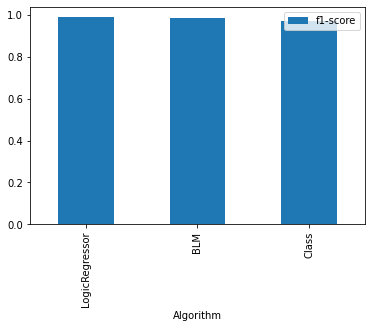

In [119]:
# Visualizing:
pd.DataFrame(results).sort_values(by='f1-score', ascending=False).plot.bar(x='Algorithm')

2.19. What do you think we could do to improve our model?

We could use decision tree to see wich features are important relevant and just train the model with dose. 

### Optional: Oversampling

2.19. Read about oversampling techniques, for example [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Use this strategy to create synthetic data and retrain our model. Compare the results. 

In [120]:
!pip install imbalanced-learn

     -------------------------------------- 199.3/199.3 kB 1.7 MB/s eta 0:00:00


In [126]:
import imblearn
from imblearn.over_sampling import SMOTE 

games	gamesstarted	mp	fg_perc	3p_perc	2p_perc	ft_perc	trb	ast	stl	...	team_SAC	team_SAS	team_SDC	team_SEA	team_TOR	team_TOT	team_UTA	team_VAN	team_WAS	team_WSB

In [127]:
nbax_train.head()

,season_id,player_id,player_season,player,season,season_start,games,gamesstarted,mp,fg_perc,...,team_POR,team_SAC,team_SAS,team_SEA,team_TOR,team_TOT,team_UTA,team_VAN,team_WAS,team_WSB
12860,12860,2346,11,Felton Spencer,2000-01,2000,0.202381,0.000000,0.144165,1.751281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4545,4547,824,1,Rick Fox,1991-92,1991,0.952381,0.060241,0.434783,0.251590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2688,2688,478,3,Keith Closs,1999-00,1999,0.666667,0.072289,0.329519,0.549401,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12703,12619,2305,5,J.R. Smith,2008-09,2008,0.952381,0.216867,0.633867,0.113321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
819,819,148,3,Andrea Bargnani,2008-09,2008,0.916667,0.710843,0.718535,0.155865,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [128]:
print("Data distribution before SMOTE\n\nTraining dataset")
print(nbay_train.value_counts())
print("\nTesting dataset")
print(nbay_test.value_counts())

Data distribution before SMOTE

Training dataset
0    10196
1      360
Name: all_nba, dtype: int64

Testing dataset
0    1804
1      59
Name: all_nba, dtype: int64


In [131]:
smote = SMOTE(random_state=8,sampling_strategy=0.2)
X_res, y_res = smote.fit_resample(nbax_train[features2], nbay_train)
print("Data distribution after SMOTE\n\nTraining dataset")
print(y_res.value_counts())

Data distribution after SMOTE

Training dataset
0    10196
1     2039
Name: all_nba, dtype: int64


In [132]:
nba_model2 = LogisticRegression(max_iter=1000, C=20)
nba_model2.fit(X_res,y_res)

LogisticRegression(C=20, max_iter=1000)

In [137]:

pr = nba_model2.predict(all_nba_2018_df[features2])
